## Recent Grad Analysis
analysis of `fivethirtyeight`'s recent graduate data, for application to the Center for Acedemic Innovation's Data Science Fellowship

### 1. Download the Data
We can do this from Jupyter, using the linux tool `subversion`, to grab only the folder from the repo we need:

In [2]:
!svn export https://github.com/fivethirtyeight/data/trunk/college-majors --force

A    college-majors
A    college-majors/all-ages.csv
A    college-majors/college-majors-rscript.R
A    college-majors/grad-students.csv
A    college-majors/majors-list.csv
A    college-majors/readme.md
A    college-majors/recent-grads.csv
A    college-majors/women-stem.csv
Exported revision 1096.


checking for our data, we see it all accounted for:

In [3]:
ls -al college-majors/

total 116
drwxrwxrwx 1 luclepot luclepot  4096 Sep 18 11:34 ./
drwxrwxrwx 1 luclepot luclepot  4096 Sep 14 17:39 ../
-rwxrwxrwx 1 luclepot luclepot 17902 Feb  9  2018 all-ages.csv*
-rwxrwxrwx 1 luclepot luclepot  9386 Feb  9  2018 college-majors-rscript.R*
-rwxrwxrwx 1 luclepot luclepot 31937 Feb  9  2018 grad-students.csv*
-rwxrwxrwx 1 luclepot luclepot  8558 Feb  9  2018 majors-list.csv*
-rwxrwxrwx 1 luclepot luclepot  2634 Feb  9  2018 readme.md*
-rwxrwxrwx 1 luclepot luclepot 26872 Feb  9  2018 recent-grads.csv*
-rwxrwxrwx 1 luclepot luclepot  6445 Feb  9  2018 women-stem.csv*


### 2. Load/Clean
We'll use Pandas for these datasets; they're pretty much ideal to be put into DataFrames. 

We only really need the 'all-ages' dataset right now, but we can write a generic function to CSV data properly.

In [4]:
import pandas as pd
import os
import numpy as np
import glob

def load(path):
    """Notebook-specific data loading function. Will load only .csv files, glob-style, with priority 
    placed on the data folder we're focusing on ('college-majors', in this case.)
    
    Args:
        path (str): glob-style string path to the file we want to load. Must match exactly one .csv file,
            otherwise errors will happen. 
        
    Returns:
        pandas.DataFrame: Loaded dataframe for the selected .csv file. 
    """
    # we only want .csv files, add this to our pathspec if it's not there
    if not path.endswith(".csv"):
        path += ".csv"
    # data will always be in our college-majors directory, so check there first for the path
    candidates = glob.glob(os.path.join("college-majors", path))
    # otherwise, check locally
    candidates = candidates if len(candidates) > 0 else glob.glob(path)
    # complain if we don't find anything
    if len(candidates) < 1:
        raise FileNotFoundError("No datasets found with path matching '{}'".format(path))
    # .. and if we find multiple datasets
    elif len(candidates) > 1:
        raise AttributeError("Multiple datasets found with path matching '{}'. Matches include: {}".format(path, candidates))
    # return loaded dataframe with selected path candidate
    selected = candidates[0]
    # helpful message, and return
    print("Loading CSV file at path '{}'".format(selected))
    return pd.read_csv(os.path.abspath(selected))
    
all_ages = load("all-ages")

Loading CSV file at path 'college-majors/all-ages.csv'


We can start by trying to clean this dataset visually. There are a few obvious issues. 

- #### Zeros in Unemployment:
There are a few categories where the number of unemployed majors is exactly zero. This might cause problems if we try to calculate some statistical quantity using the unemployment (rate) later. We can see this by sorting the table by unemployment rate:


In [5]:
all_ages.sort_values('Unemployment_rate').head(5)

,Major_code,Major,Major_category,Total,Employed,Employed_full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th
26,2301,EDUCATIONAL ADMINISTRATION AND SUPERVISION,Education,4037,3113,2468,0,0.000000,58000,44750,79000.0
51,2411,GEOLOGICAL AND GEOPHYSICAL ENGINEERING,Engineering,6264,4120,3350,0,0.000000,85000,55000,125000.0
85,3607,PHARMACOLOGY,Biology & Life Science,5015,3481,2579,57,0.016111,60000,35000,105000.0
111,5008,MATERIALS SCIENCE,Engineering,7208,5866,4505,134,0.022333,75000,60000,100000.0
97,4005,MATHEMATICS AND COMPUTER SCIENCE,Computers & Mathematics,7184,5874,5039,150,0.024900,92000,53000,136000.0


- #### Widely Varying Stats:
The statistics vary quite a bit based on the major. This might be something we want to account for when creating visualizations. 

    We can see this by checking the counts between the smallest/largest majors, which vary by a factor of about 1000:

In [7]:
all_ages.sort_values("Total")[::len(all_ages)-1]

,Major_code,Major,Major_category,Total,Employed,Employed_full_time_year_round,Unemployed,Unemployment_rate,Median,P25th,P75th
27,2303,SCHOOL STUDENT COUNSELING,Education,2396,1492,1093,169,0.101746,41000,33200,50000.0
161,6203,BUSINESS MANAGEMENT AND ADMINISTRATION,Business,3123510,2354398,1939384,147261,0.058865,58000,39500,86000.0


- #### Missing survey category from 'Total' Count:
The last possible problem with the dataset is that the `Total` category is not actually the sum of the `Employed` and `Unemployed` categories, meaning there is another survey category that is unaccounted for.

    In fact, there are no categories at all where `Employed + Unemployed = Total`: 

In [8]:
((all_ages.Unemployed + all_ages.Employed) == all_ages.Total).any()

False

We can check whether `Unemployment_rate` is given by $r = \frac{U}{U + E}$ or by $r = \frac{U}{T}$ (with $T$ being `Total`, $U$ being `Unemployed`, and $E$ being `Employed`:

In [9]:
r1 = all_ages.Unemployed/(all_ages.Unemployed + all_ages.Employed)
r2 = all_ages.Unemployed/all_ages.Total

print("r1: ", np.isclose(r1, all_ages.Unemployment_rate).all())
print("r2: ", np.isclose(r2, all_ages.Unemployment_rate).all())

r1:  True
r2:  False


So the unemployment rate is calculated using a total from the given `Employment` and `Unemployment` categories, independent of the reported `Total` column. This might be good to know later. 

### 3. Unemployment Rates by Major
We can now look into the unemployment rate distribution. This is given by the aptly named `'Unemployment_rate'`variable.

We can pare our dataset to contain this variable, the major name/id, and the total major statistics count (useful for calculating uncertainties, etc.)

In [10]:
keep = ['Major', 'Unemployment_rate', 'Major_code', 'Unemployed', 'Employed', 'Major_category']
pared = all_ages.drop([c for c in all_ages.columns if c not in keep], axis=1)
pared.head(5)

,Major_code,Major,Major_category,Employed,Unemployed,Unemployment_rate
0,1100,GENERAL AGRICULTURE,Agriculture & Natural Resources,90245,2423,0.026147
1,1101,AGRICULTURE PRODUCTION AND MANAGEMENT,Agriculture & Natural Resources,76865,2266,0.028636
2,1102,AGRICULTURAL ECONOMICS,Agriculture & Natural Resources,26321,821,0.030248
3,1103,ANIMAL SCIENCES,Agriculture & Natural Resources,81177,3619,0.042679
4,1104,FOOD SCIENCE,Agriculture & Natural Resources,17281,894,0.049188


This is a lot of data points, which is probably the point of this exercise. One way to plot this would be to plot each major's unemployment rate in a barchart. 

We want to sort the majors in some way, because otherwise there are too many to visually deal with. One way to do this would be to sort by `Major_category`, and then again by `Unemployment_rate`. In this way, we can see the overarching highest/lowest unemployment rates, as well as the highest/lowest in each major category. Lastly, we can use some color to differentiate between major categories. This is easy to do using rectangular patches (i.e. manually). 

The resulting plot is fairly dense with information, but still legible. We could probably clean things up even more by plotting the bars horizontally and playing with plotting parameters to make the labels prettier, but I don't really have time to do that right now.

If this were integrated into a website, we'd probably want to include some kind of selector function which filters out majors/major categories as the user sees fit.

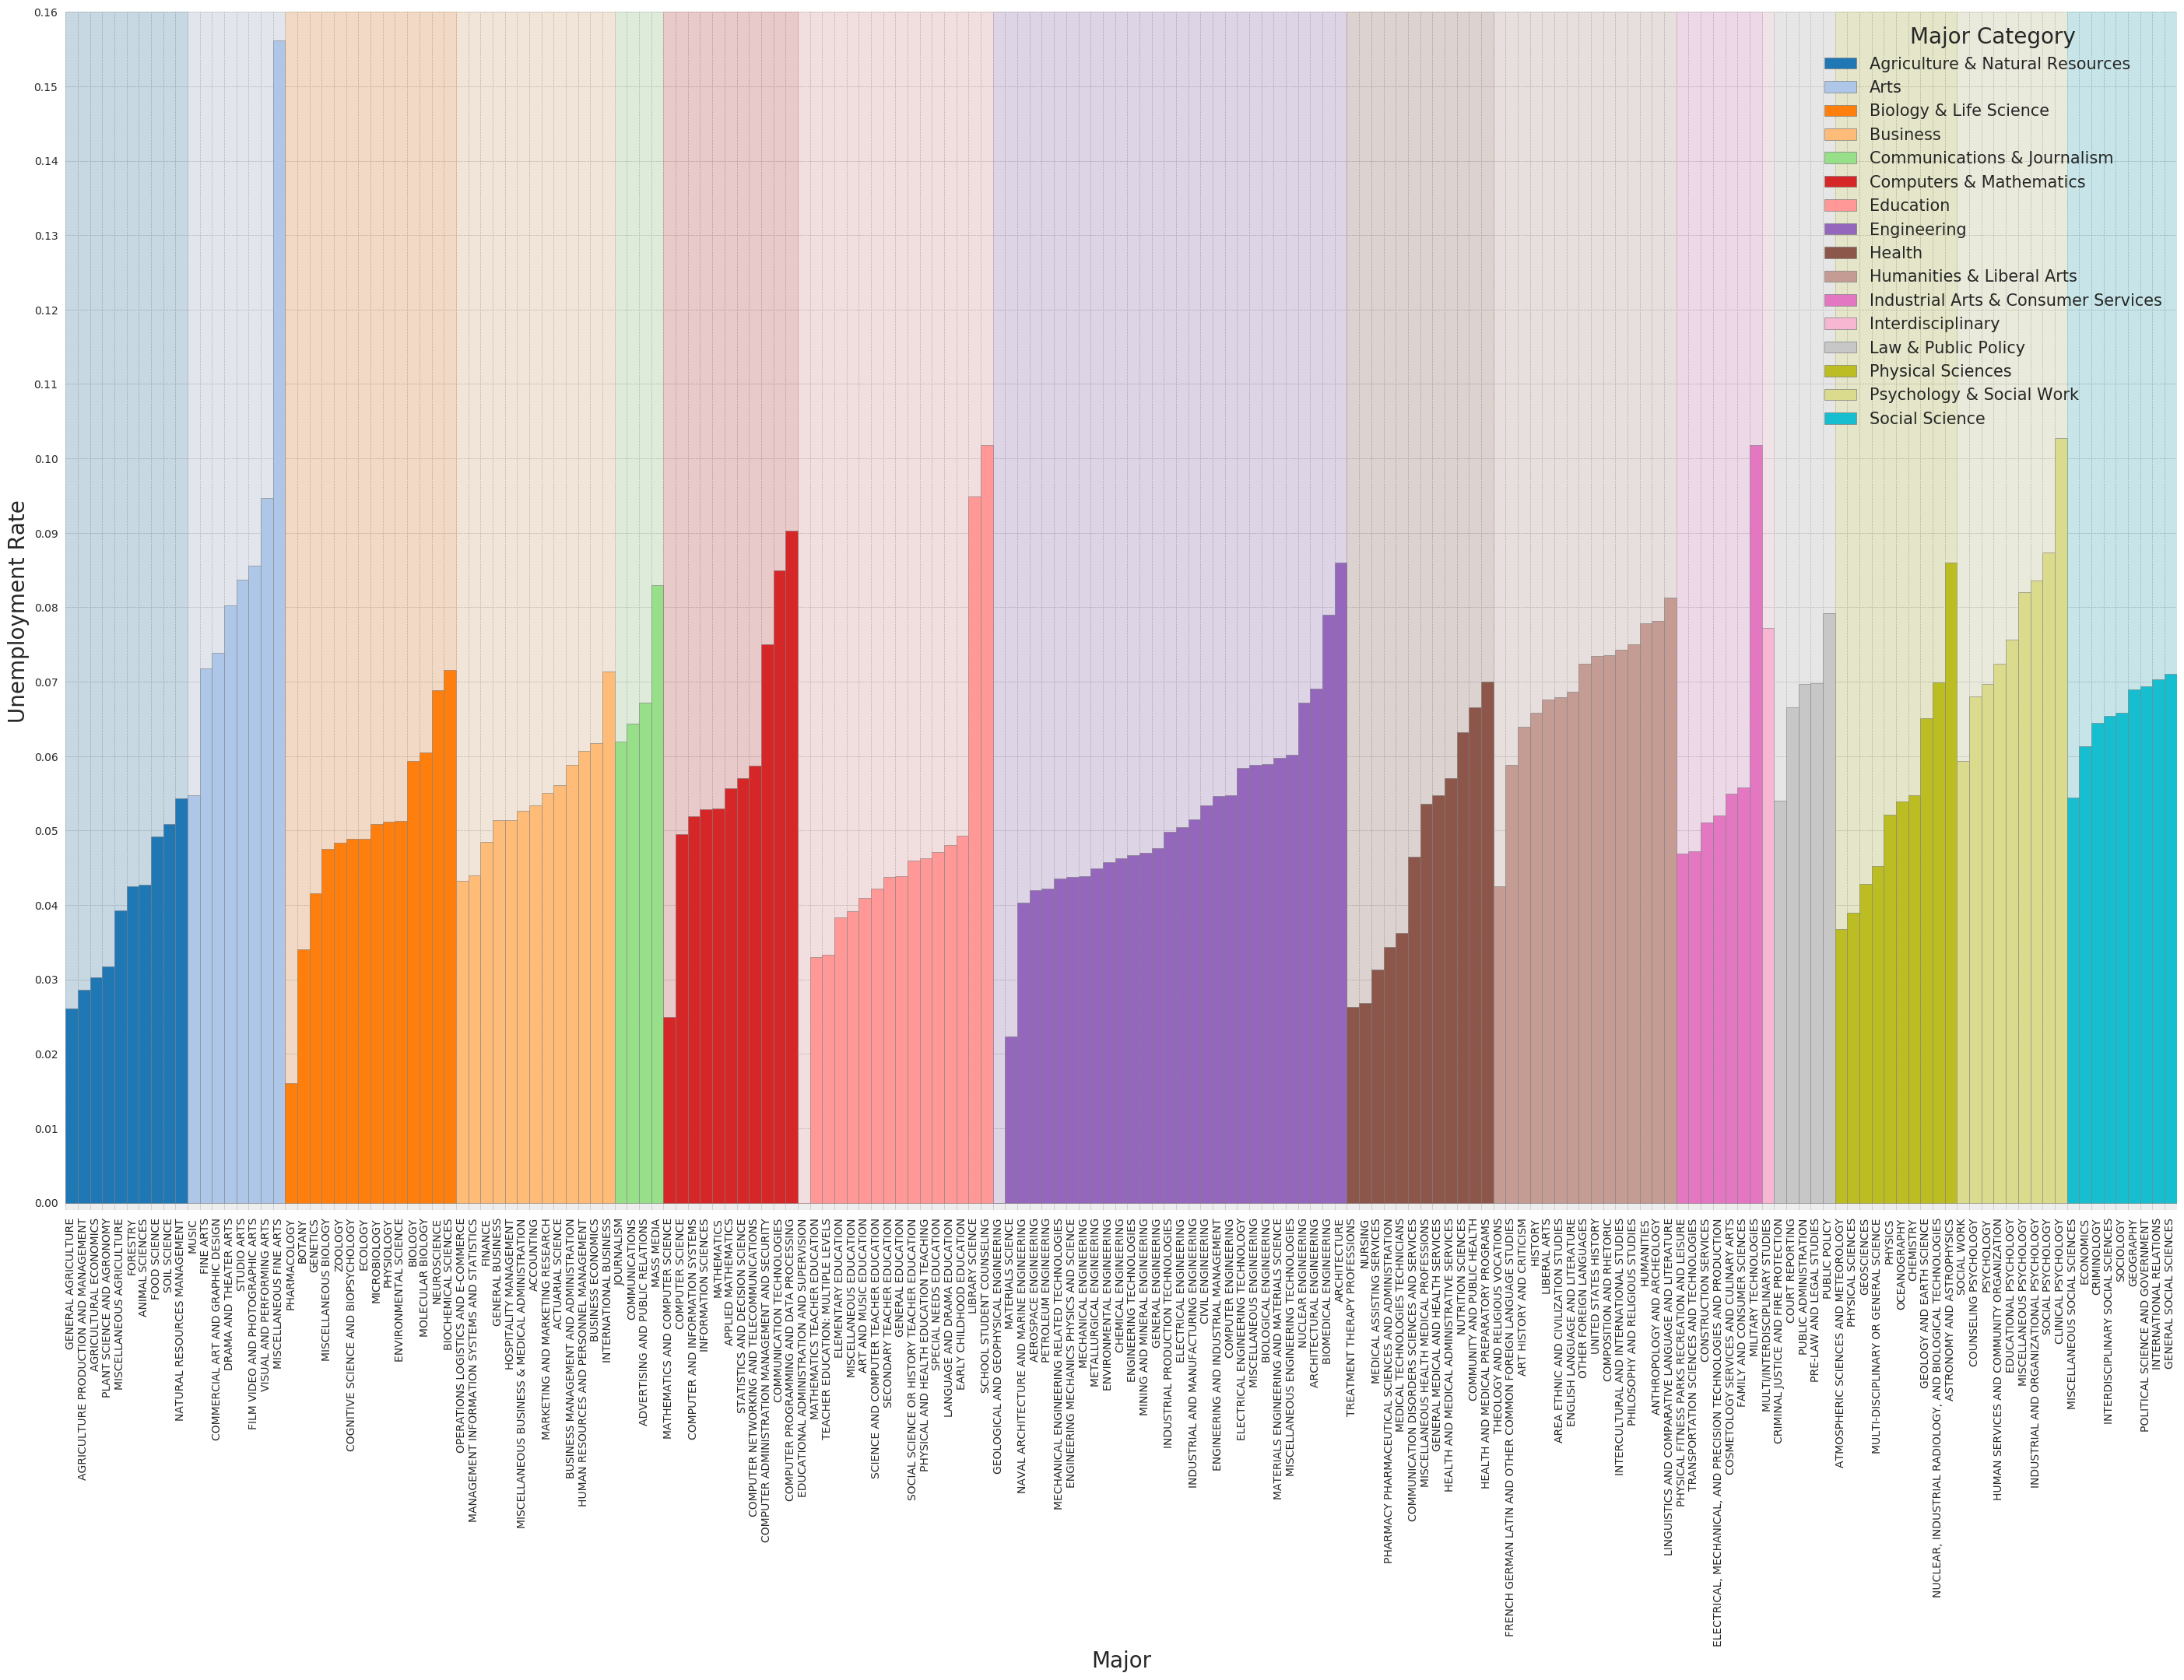

In [183]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches

# grab a nice style
mpl.style.use('bmh')

# sort by major category, then unemployment rate
sort = pared.sort_values(['Major_category', 'Unemployment_rate'])

# create categories list, and colors for plotting
categories = np.unique(sort.Major_category)
colormap = plt.get_cmap('tab20')
colors = [colormap(1.*i/len(categories)) for i in range(len(categories))]

# create subplots (really just for initing figure size)
plt.subplots(figsize=(35,20))

# number of majors plotted so far
n = 0 
for i,category in enumerate(categories):
    
    # grab all majors matching the current category
    subsort = sort[sort.Major_category == category]

    # bar plot of current category, with rate, etc.
    plt.bar(
        subsort.Major, subsort.Unemployment_rate,
        label=category, color=colors[i], 
        align='edge', width=1., alpha=1., 
        edgecolor='grey'
    )

    # background color patch for current major
    plt.gca().add_patch(
        patches.Rectangle((n,0), width=len(subsort), height=.16, color=colors[i], alpha=0.18)
    )
    n +=  len(subsort)

# limits, axis labels, etc.
plt.ylim(-0.001, .16)
plt.xlim(0, n)

plt.xlabel("Major", fontsize=20)
plt.ylabel("Unemployment Rate", fontsize=20)

plt.xticks(rotation=90, ha='left')
plt.yticks(np.arange(0., (int(100*sort.Unemployment_rate.max()) + 2.)/100., 1./100))

plt.legend(fontsize=15, title="Major Category", loc='upper right')
plt.setp(plt.gca().get_legend().get_title(),fontsize='20')
plt.show()